# Fig 4 - Mutation map

In preparation to this norebook please execute the Snakefile `Snakefile_mutationmaps` by running `cd src/mutationmaps; snakemake --use-conda` make sure that conda is setup correctly and that you have snakemake intalled in the environment you are using!

For the rest of this notebook it is important that you have installed `pip install kipoi[vep]` in the environment in which you are executing this notebook.

In [1]:
from collections import OrderedDict
MODEL_NAME_DICT = OrderedDict([('pwm', 'pwm_HOCOMOCO/human/GATA1'), ('lsgkm', 'lsgkm-SVM/Tfbs/Gata1/Pbde/Sydh_Ucd'),
('deepbind', 'DeepBind/Homo_sapiens/TF/D00765.001_ChIP-seq_GATA1'), ('deepsea','DeepSEA/variantEffects')])


from kipoi.postprocessing.variant_effects.mutation_map import MutationMapPlotter
model_mms = OrderedDict()

for model_label in MODEL_NAME_DICT:
    hdf5_file = "../../data/processed/mutation_map/computed/{model}.hdf5".format(model = model_label)
    model_mms[model_label] = MutationMapPlotter(fname=hdf5_file)

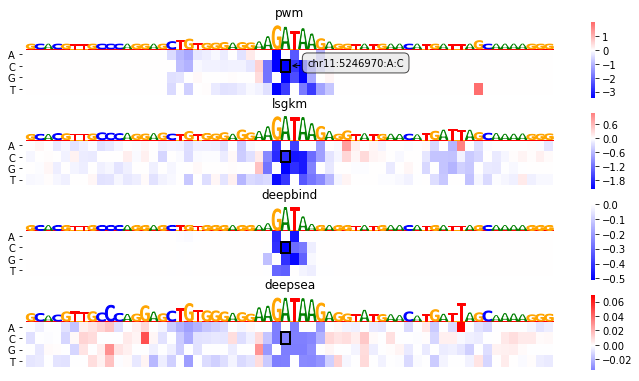

In [2]:
# Mutation map with stars for the clinvar variants
# /nfs/research1/stegle/users/rkreuzhu/opt/manuscript_code/data/raw/clinvar/clinvar_20180603.vcf.gz

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import gridspec
from collections import OrderedDict
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


region_limits = [(5246970 - 30, 5246970+30)]

sel_model_outputs= {'pwm':'0',
  'lsgkm': '0',
  'deepbind':'0',
  'deepsea':"K562_GATA-1_None_622"}


fig = plt.figure(figsize=(12,6.4))
gs = gridspec.GridSpec(4,1, hspace=0.2, wspace=0.1)


for i, model in enumerate(model_mms):
    ax = plt.subplot(gs[i, 0])
    model_mms[model].plot_mutmap(0,"seq", "diff", sel_model_outputs[model], 
                                   ax = ax, limit_region_genomic = region_limits[0], 
                                   minimum_letter_height = 0.2,show_var_id=i==0)
    ax.set_title(model)

plt.show()

# Alternative way to highlight other variants

It is possible to highlight variants using the `plot_mutmap` command, but here we want to display ClinVar variants as asterisks in the heatmap. Therefor we first calculate the position of those asterisks:

In [3]:
import cyvcf2
vcf_fh = cyvcf2.VCF("../../data/raw/mutation_map/ClinVar/clinvar_20180603.vcf.gz")

clinvar_elms = []
x_offset = region_limits[0][0]
y_offset = {"A":0, "C":-1, "G":-2, "T":-3}
color_code = {"Pathogenic": "red", "Pathogenic,_other": "red", "Likely_pathogenic": "red",
             "other": "grey","Uncertain_significance": "grey", "Conflicting_interpretations_of_pathogenicity": "grey",
             "Likely_benign": "green"}
for rec in vcf_fh("%s:%d-%d"%("11", region_limits[0][0]+1, region_limits[0][1])):
    if rec.is_indel:
        continue
    clinsig = dict(rec.INFO)['CLNSIG']
    clinvar_elms.append({"x":rec.POS - x_offset, "y":y_offset[rec.ALT[0]], "signif":clinsig, "color":color_code[clinsig]})
    
import pandas as pd
clinvar_elms = pd.DataFrame(clinvar_elms)

And then we plot them - look at the one additional line starting with `plt.scatter`:

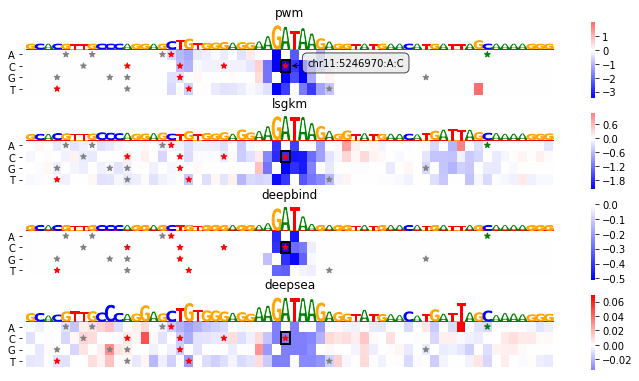

In [4]:
fig = plt.figure(figsize=(12,6.4))
gs = gridspec.GridSpec(4,1, hspace=0.2, wspace=0.1)


for i, model in enumerate(model_mms):
    ax = plt.subplot(gs[i, 0])
    model_mms[model].plot_mutmap(0,"seq", "diff", sel_model_outputs[model], 
                                   ax = ax, limit_region_genomic = region_limits[0], 
                                   minimum_letter_height = 0.2,show_var_id=i==0)
    plt.scatter(clinvar_elms["x"], clinvar_elms["y"]-0.5, c=clinvar_elms["color"], marker="*")
    ax.set_title(model)

plt.show()